Data Requisition (Kaggle) + Importing Libraries

In [ ]:
# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
competition_name = "awsaf49/coco-2017-dataset"

# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/MyDrive/ML_Projects/Image_Captioning/Dataset/kaggle.json"

! pip install kaggle --quiet
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Image_Captioning/Dataset/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#! kaggle datasets download -d {competition_name}

!kaggle datasets download -d {competition_name} -p /content/drive/MyDrive/Image_Captioning/Dataset


#! mkdir /content/drive/MyDrive/Image_Captioning/Dataset
#! unzip {competition_name + ".zip"} -d kaggle_data

# Unmount your Google Drive
#drive.flush_and_unmount()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 25.0G/25.0G [17:55<00:00, 25.9MB/s]
100% 25.0G/25.0G [17:55<00:00, 25.0MB/s]


In [ ]:
!unzip -j /content/drive/MyDrive/Image_Captioning/Dataset/coco-2017-dataset.zip 'coco2017/train2017/*' -d /content/drive/MyDrive/TrainingImgs

In [ ]:
import os
import glob

# Specify the directory containing the images
image_directory = "/content/drive/MyDrive/TrainingImgs"

# Use glob to get a list of all image files in the directory
image_files = glob.glob(os.path.join(image_directory, '*.jpg'))  # Adjust the file extension as needed

# Get the number of images
num_images = len(image_files)

print(f"Number of images in the directory: {num_images}")

In [ ]:
import urllib.request
import os
import json
import warnings
warnings.filterwarnings('ignore')
import collections
import string
from pycocotools.coco import COCO

import random
from tqdm import tqdm
import numpy as np
import pickle

# Tensorflow & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import Input

# Loading Training Data (Images + Captions) and Preprocessing

In [ ]:
annotations='/content/drive/MyDrive/coco2017/annotations/captions_train2017.json'
image_directory ="/content/drive/MyDrive/TrainingImgs"

In [ ]:
# Function for loading json data
def loading_json_data(annotations):
  with open(annotations, 'r') as annotation:
    annotation_json=json.load(annotation)
  return annotation_json

# Formatting captions - changing to lower case and removing captions
def annotation_json_formatting(caption):
  punctuation_removal=str.maketrans('','',string.punctuation)
  caption = [word.lower().translate(punctuation_removal) for word in caption.split()]
  return ' '.join(caption)

# Storing the formatted caption and metadata in a collection dictionary
def annnotated_data_storage(annotations):
  annotation_json=loading_json_data(annotations)
  #print(annotation_json['annotations'][3])
  Oraganized_data=collections.defaultdict(list)
  for item in annotation_json['annotations']:
    formatted_caption= annotation_json_formatting(item['caption'])
    #print(formatted_caption)
    image_filename= f"{item['image_id']:012}.jpg"
    image_path= os.path.join(image_directory,image_filename)
    # creating a deafultdict in list format storing the image paths and respective captions
    Oraganized_data[image_path].append(formatted_caption)
  return dict(Oraganized_data)

  # organizing data and storing as a dictionary
Oraganized_imagepath_captions=annnotated_data_storage(annotations)

Reducing the size of the dataset

In [ ]:
# Reducing the dataset size by sampling a subset
imagepath_caption_reduce = dict(random.sample(dict(Oraganized_imagepath_captions).items(),
                              int(len(dict(Oraganized_imagepath_captions)) * 0.5)))

Storing Image IDs and their path

In [ ]:
# Mapping Image IDs to the Oragnized default dict

def path_to_image_id_mapping(caption_collection):
    Mapping=collections.defaultdict(list)
    for img_path, captions_list in caption_collection.items():
        img_identifier = os.path.basename(img_path).rstrip('.jpg')
        Mapping[img_identifier] = captions_list
    return dict(Mapping)

# Substituiting Image paths with Image ID
ImageID_captions_reduce = path_to_image_id_mapping(imagepath_caption_reduce)
# extracting all the image ids and storing
ImageIDs = list(ImageID_captions_reduce.keys())
# extracting all the images and storing
ImagePaths = list(imagepath_caption_reduce.keys())

Processing the caption

In [ ]:
lines =[f"{path} {description}"
        for path,description_list in ImageID_captions_reduce.items()
        for description in description_list ]
print(lines[:2])

# Initializing a dictionary to hold batch of processed descriptions
descriptions_batch = {}
#processing each line in the description as
for line in tqdm(lines):
  if not line.strip():
    continue
  imgid, *img_description = line.split()
  # Adding 'startseq' and 'endseq' tokens to each description
  if imgid in list(ImageID_captions_reduce.keys()):
    desc = 'startseq {} endseq'.format(' '.join(img_description))
    descriptions_batch.setdefault(imgid, []).append(desc)

['000000039509 two people lay on the beach under umbrellas facing the water', '000000039509 if you have some people on a beach by the ocean']


100%|██████████| 295886/295886 [05:44<00:00, 857.98it/s]


Vector embedding of captions using GloVe

In [ ]:
from typing_extensions import Counter
import itertools
#creating file with all processed sequences
captions_batch = list(itertools.chain.from_iterable(descriptions_batch.values()))
#Genearting vocabulary from caption
words=[word for sent in captions_batch for word in sent.split()]
vocab = [word for word, count in Counter(words).items() if count >=10]

# Creating word-to-index and index-to-word mappings
wordtoix = {word: index+1 for index, word in enumerate(vocab)}
ixtoword = {index: word for word, index in wordtoix.items()}
vocab_size= len(ixtoword) + 1

# determining the max length of description
alldesc = [desc for descs in descriptions_batch.values() for desc in descs]
maxlen = max(map(lambda x: len(x.split()), alldesc))

#dictionary for storing word embeddings
embedding_map={}
with open('/content/drive/MyDrive/Image_Captioning/Dataset/glove.6B.200d.txt',encoding="utf-8") as f:
  for line in f:
    values = line.strip().split()
    embedding_map[values[0]] = np.asarray(values[1:], dtype='float32')

# Defining the embedding dimension
embedding_dim = 200
embedding_mat = np.zeros((vocab_size, embedding_dim))

# Populating the embedding matrix with known embeddings
embeddings_keep = {wordtoix[word]: embedding_map[word] for word in wordtoix if word in embedding_map}
for index, embeds in embeddings_keep.items():
    embedding_mat[index] = embeds


In [ ]:
# Set GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if not physical_devices:
    raise RuntimeError("No GPU devices found.")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Extracting Image features using Inception V3 and storing in dictionary

In [ ]:
# Setting up the InceptionV3 model for image feature extraction
base_model = InceptionV3(weights='imagenet')
model_new = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Function to preprocess input images for the model
def image_preprocessing(im_path):
    image = load_img(im_path, target_size=(299, 299))
    image_arr = img_to_array(image)
    image_arr = np.expand_dims(image_arr, axis=0)
    return preprocess_input(image_arr)

# Extracting feature vectors from preprocessed images
def fetch_encoding(im_path):
    processed_image = image_preprocessing(im_path)
    feature_vector = model_new.predict(processed_image)
    return np.squeeze(feature_vector)

# Processing all training images to get their feature vectors
#ImagePaths = [...]  # Specify your list of image paths
training_data = {os.path.basename(im_path): fetch_encoding(im_path) for im_path in tqdm(ImagePaths)}

# Defining the path to save the training data
save_path = '/content/drive/MyDrive/training_data_final.pkl'

# Saving the training data to a file using pickle
with open(save_path, 'wb') as file:
    pickle.dump(training_data, file, protocol=pickle.HIGHEST_PROTOCOL)

print("Training data saved successfully.")

Saving the Image Feature Encodings

In [ ]:
# Defining the path to save the training data
save_path = '/content/drive/MyDrive/training_data_1027231301.pkl'

# Saving the training data to a file using pickle
with open(save_path, 'wb') as file:
    pickle.dump(training_data, file, protocol=pickle.HIGHEST_PROTOCOL)

# Loading the training data back from the file
with open(save_path, 'rb') as file:
    training_data_loaded = pickle.load(file)

# Assigning the loaded data to the original variable
training_data = training_data_loaded

Processing the captions into sequences for training + Creating batches of input data for training

In [ ]:
# Function to preprocess a given description into sequences for training
def preprocess_description(desc, wordtoix, max_length):
    seq = [wordtoix.get(word) for word in desc.split() if word in wordtoix]
    seq = [s for s in seq if s is not None]
    X2, y = [], []

    # Create input-output pairs from the sequence
    for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        X2.append(in_seq)
        y.append(out_seq)
    return X2, y

# Generator function to yield batches of data for training
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    while True:
        for key, desc_list in descriptions.items():
            photo = photos.get(key + '.jpg')
            if photo is None:
                continue

            # Process each description for the photo
            for desc in desc_list:
                in_seqs, out_seqs = preprocess_description(desc, wordtoix, max_length)
                X1.extend([photo] * len(in_seqs))
                X2.extend(in_seqs)
                y.extend(out_seqs)

            # Yield a batch of data when the desired batch size is reached
            if len(X1) >= num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = [], [], []


Creating the NN architechture for modelling

In [ ]:
# Create initial feature layer
def feature_extractor(input_shape):
    inputs = Input(shape=input_shape)
    x = Dropout(0.5)(inputs)
    x = Dense(256, activation='relu')(x)
    return inputs, x

# Create sequence generator
def sequence_processor(input_shape, vocab_size, embedding_dim, embedding_mat):
    inputs = Input(shape=input_shape)
    x = Embedding(vocab_size, embedding_dim, mask_zero=True, weights=[embedding_mat], trainable=False)(inputs)
    x = Dropout(0.5)(x)
    x = LSTM(256)(x)
    return inputs, x

# Combine the entire model
def model_assembler(feature_output, sequence_output, vocab_size):
    x = add([feature_output, sequence_output])
    x = Dense(256, activation='relu')(x)
    return Dense(vocab_size, activation='softmax')(x)

# Funnel the features through the built model
feature_input, feature_output = feature_extractor((2048,))
sequence_input, sequence_output = sequence_processor((maxlen,), vocab_size, embedding_dim, embedding_mat)
outputs = model_assembler(feature_output, sequence_output, vocab_size)

# Create the model
model = Model(inputs=[feature_input, sequence_input], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 51, 200)              1084800   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [ ]:
# Set training hyperparams
epochs = 20
batch_size = 64
steps = len(descriptions_batch) // batch_size
generator = data_generator(descriptions_batch, training_data, wordtoix, maxlen, batch_size)

# Fit the model
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/20
924/924 [==============================] - 95s 96ms/step - loss: 4.7006 - accuracy: 0.2646
Epoch 2/20
924/924 [==============================] - 89s 96ms/step - loss: 3.9880 - accuracy: 0.3217
Epoch 3/20
924/924 [==============================] - 88s 95ms/step - loss: 3.6548 - accuracy: 0.3496
Epoch 4/20
924/924 [==============================] - 88s 95ms/step - loss: 3.5216 - accuracy: 0.3617
Epoch 5/20
924/924 [==============================] - 87s 94ms/step - loss: 3.4128 - accuracy: 0.3729
Epoch 6/20
924/924 [==============================] - 90s 98ms/step - loss: 3.3492 - accuracy: 0.3804
Epoch 7/20
924/924 [==============================] - 89s 96ms/step - loss: 3.2902 - accuracy: 0.3828
Epoch 8/20
924/924 [==============================] - 88s 95ms/step - loss: 3.2655 - accuracy: 0.3899
Epoch 9/20
924/924 [==============================] - 87s 94ms/step - loss: 3.2152 - accuracy: 0.3946
Epoch 10/20
924/924 [==============================] - 87s 94ms/step - loss: 3.175

In [ ]:
# Specify the directory path to save the model
model_dir = '/content/drive/MyDrive'

# Save the model in the SavedModel format
tf.saved_model.save(model, model_dir)

Model generated caption (Using example from training data)

1/1 [==============================] - 0s 28ms/step


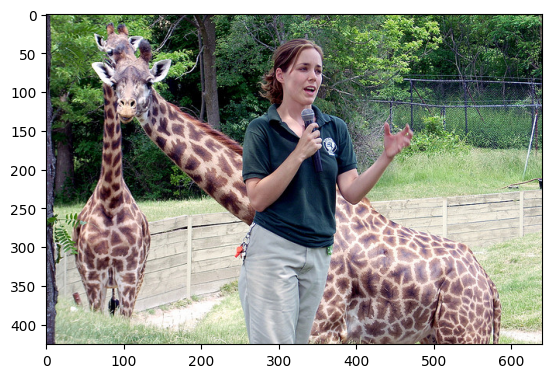

a giraffe standing in a field with a tree


'a giraffe standing in a field with a tree'

In [ ]:
import matplotlib.pyplot as plt

# Generate a caption given a path
def generate_caption(photo, max_len=maxlen):
    caption = ['startseq']

    for _ in range(max_len):
        tokens = [wordtoix[word] for word in caption if word in wordtoix]
        tokens_padded = pad_sequences([tokens], maxlen=max_len)
        predicted_word_index = np.argmax(model.predict([photo, tokens_padded], verbose=0))
        predicted_word = ixtoword[predicted_word_index]
        if predicted_word == 'endseq':
            break
        caption.append(predicted_word)
    processed_caption = caption[1:]
    if 'endseq' in processed_caption:
        processed_caption.remove('endseq')
    return ' '.join(processed_caption)

# Get a caption given a path
def get_caption(im_path):
    image = fetch_encoding(im_path)
    image = image.reshape((1, 2048))
    x=plt.imread(im_path)
    plt.imshow(x)
    plt.show()
    print(generate_caption(image))
    return generate_caption(image)

# Get example image
get_caption('/content/drive/MyDrive/TrainingImgs/000000266677.jpg')

In [ ]:
!unzip -j /content/drive/MyDrive/Image_Captioning/Dataset/coco-2017-dataset.zip 'coco2017/val2017/*' -d /content/drive/MyDrive/valImgs

In [ ]:
pip install pycocoevalcap

Testing the model with validation dataset and analyzing the metrics

In [ ]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

# Defining the directory path for validation images
folder_path = '/content/drive/MyDrive/valImgs'
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Constructing the full path for each image file
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

# List to store generated captions for each image
all_captions = []

# Processing each image to generate captions
for image_file in tqdm(image_files):
    image_path = os.path.join(folder_path, image_file)
    temp_dict = dict()

    # Extracting image ID and encoding from image path
    image_id = int(str(image_path).split('.')[0].split('/')[-1].lstrip('0'))
    image = fetch_encoding(image_path)
    image = image.reshape((1, 2048))

    # Generating caption for the image
    image_caption = generate_caption(image)
    temp_dict["image_id"] = image_id
    temp_dict["caption"] = image_caption
    all_captions.append(temp_dict)

# Saving all generated captions to a JSON file
try:
    with open('/content/drive/MyDrive/results.json', 'w') as f:
        json.dump(all_captions, f)
except:
    pass

# Defining paths for annotation and results files
annotation_file = '/content/drive/MyDrive/captions_train2017.json'
results_file = '/content/drive/MyDrive/results.json'

# Evaluating generated captions against ground truth using COCO tools
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)
coco_eval = COCOEvalCap(coco, coco_result)
coco_eval.evaluate()

# Displaying evaluation scores for various metrics
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')


In [ ]:
with open(results_file, 'r') as result:
    result_json=json.load(result)

Using cocoevalcap for evalution of generated captions

In [ ]:
# Defining paths for annotation and results files
annotation_file = '/content/drive/MyDrive/captions_val2017.json'
results_file = '/content/drive/MyDrive/results.json'

# Evaluating generated captions against ground truth using COCO tools
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)
coco_eval = COCOEvalCap(coco, coco_result)
coco_eval.evaluate()

# Displaying evaluation scores for various metrics
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 49604, 'reflen': 48801, 'guess': [49604, 44604, 39604, 34604], 'correct': [29693, 11759, 3997, 1375]}
ratio: 1.0164545808487324
Bleu_1: 0.599
Bleu_2: 0.397
Bleu_3: 0.252
Bleu_4: 0.159
computing METEOR score...
METEOR: 0.182
computing Rouge score...
ROUGE_L: 0.436
computing CIDEr score...
CIDEr: 0.494
computing SPICE score...
SPICE: 0.108
Bleu_1: 0.599
Bleu_2: 0.397
Bleu_3: 0.252
Bleu_4: 0.159
METEOR: 0.182
ROUGE_L: 0.436
CIDEr: 0.494
SPICE: 0.108
